# Text Analysis on MP-Groups

This notebook will analyse properties of the text. The text itself has more potential than I have time, and hence some specific target shall be made!

* Setting a target for analysis
  * What exactly are we analysing?
  * Which WORDS have the greatest VARIANCE among GROUPS


1. Setting **limitations** for data which is analyzed
   1. Comparison between **groups** or invidivual MPs and ministers
      
      → In practice, selecting an appropriate dataframe / table from SQLite
   2. **Excluding** / including **interjections**
   3. Selecting maximum and minimum document frequency depending on whether we want to discover topics which are **generally popular** among all or ones which come up frequently only by some groups
      * low min_df → less relevant stuff is also included
      * high min_df → less relevant stuff is excluded
      * high max_df → really popular stuff is also included
      * low max_df → really popular stuff is excluded

   4. Selecting whether certain columns should be still excluded.
      * This can be also done as a part of defining stopwords. For instance, should verbs and adjectives be excluded?
        * While descriptive to a certain extent, figuring out the topic based on them is challenging
   5. Selecting whether certain rows should be excluded.
      * The rows aren't equal. Some have mainly swedish words which aren't currently dealt with well enough. Others represent single person rather than a party of multiple people



2. Selecting the method
   * Using TF-IDF Vectorizer as the base method to get relevance of a word
     * Further, currently covered:
     1. **Bar charts of TF-IDF sorted by variance** to uncover topics which some view as important and others do not.
     2. **Correlation matrix** to get approximate overviews between parties
     * In future, KMeans clustering combined with dimensionality reduction might be also an interesting approach, but that won't be covered in this version.

### Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS  # As of DEC 2022, I didn't end up using this library in the latest version yet.
from IPython.core.pylabtools import figsize
figsize(30,10)

In [2]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///eduskunta.db', echo=False)

In [3]:
pvt_groups_lem = pd.read_sql_table(table_name="puheenvuorot_grouped_by_groups_lem", con=engine)
pvt_groups_lem = pvt_groups_lem.set_index("Eduskuntaryhmä")

In [4]:
pvt_bt_lem_full = pd.read_sql_table(table_name="puheenvuorot_bad_times_pvt_lem", con=engine)

In [5]:
pvt_groups_lem.head()

,Puheenvuoro Lem,Puheenvuoro Lem ilman keskeytyksiä
Eduskuntaryhmä,,
-,arvoisa puhemies ! esitys ehdottaa muutettava ...,arvoisa puhemies ! esitys ehdottaa muutettava ...
at,arvoisa rouva puhemies ! perustuslaki pykälä k...,arvoisa rouva puhemies ! perustuslaki pykälä k...
kd,arvoisa puhemies ! käsiteltävä olla siis valti...,arvoisa puhemies ! käsiteltävä olla siis valti...
kesk,arvoisa rouva puhemies ! ei tämä olla kyse kuu...,arvoisa rouva puhemies ! ei tämä olla kyse kuu...
kok,arvoisa rouva puhemies ! arvoisa Suomi kansa e...,arvoisa rouva puhemies ! arvoisa Suomi kansa e...


Sci-kit learn can be used to figure out the topics parties talk about more than others

In [6]:
party_codes = list(pvt_bt_lem_full["Eduskuntaryhmä"].unique())

# vas should be "BF1E24" but it's really close to sd, so change it to a darker #5f0f11
color_codes = ["#FFD500", "#E11931", "#5f0f11", "#006288", "#FFDD93", "#01954B", "#2B67C9", "#CCCCCC", "#61BF1A", "#ae2375", "#7475a6", "#000000"]
color_dict = dict(zip(party_codes, color_codes))


### Stopwords

#### Initial stopwords

Some initial filtering is commenced by using stopwords.

**Some bias is already included in the stopwords**, but they're mainly either contextual words (as in, parliament-related technical words) or particles with little to no significance.

In [7]:
stopwords = list(STOPWORDS)
fi_stopwords = ["Arvoisa", "rouva", "herra", "puhemies!", "arvoisa"]
fi_stopwords.extend(["aiemmin","aika","aikaa","aikaan","aikaisemmin","aikaisin","aikajen","aikana","aikoina","aikoo","aikovat","aina","ainakaan","ainakin","ainoa","ainoat","aiomme","aion","aiotte","aist","aivan","ajan","alas","alemmas","alkuisin","alkuun","alla","alle","aloitamme","aloitan","aloitat","aloitatte","aloitattivat","aloitettava","aloitettevaksi","aloitettu","aloitimme","aloitin","aloitit","aloititte","aloittaa","aloittamatta","aloitti","aloittivat","alta","aluksi","alussa","alusta","annettavaksi","annetteva","annettu","ansiosta","antaa","antamatta","antoi","aoua","apu","asia","asiaa","asian","asiasta","asiat","asioiden","asioihin","asioita","asti","avuksi","avulla","avun","avutta","edelle","edelleen","edellä","edeltä","edemmäs","edes","edessä","edestä","ehkä","ei","eikä","eilen","eivät","eli","ellei","elleivät","ellemme","ellen","ellet","ellette","emme","en","enemmän","eniten","ennen","ensi","ensimmäinen","ensimmäiseksi","ensimmäisen","ensimmäisenä","ensimmäiset","ensimmäisiksi","ensimmäisinä","ensimmäisiä","ensimmäistä","ensin","entinen","entisen","entisiä","entisten","entistä","enää","eri","erittäin","erityisesti","eräiden","eräs","eräät","esi","esiin","esillä","esimerkiksi","et","eteen","etenkin","etessa","ette","ettei","että","haikki","halua","haluaa","haluamatta","haluamme","haluan","haluat","haluatte","haluavat","halunnut","halusi","halusimme","halusin","halusit","halusitte","halusivat","halutessa","haluton","he","hei","heidän","heidät","heihin","heille","heillä","heiltä","heissä","heistä","heitä","helposti","heti","hetkellä","hieman","hitaasti","hoikein","huolimatta","huomenna","hyvien","hyviin","hyviksi","hyville","hyviltä","hyvin","hyvinä","hyvissä","hyvistä","hyviä","hyvä","hyvät","hyvää","hän","häneen","hänelle","hänellä","häneltä","hänen","hänessä","hänestä","hänet","häntä","ihan","ilman","ilmeisesti","itse","itsensä","itseään","ja","jo","johon","joiden","joihin","joiksi","joilla","joille","joilta","joina","joissa","joista","joita","joka","jokainen","jokin","joko","joksi","joku","jolla","jolle","jolloin","jolta","jompikumpi","jona","jonka","jonkin","jonne","joo","jopa","jos","joskus","jossa","josta","jota","jotain","joten","jotenkin","jotenkuten","jotka","jotta","jouduimme","jouduin","jouduit","jouduitte","joudumme","joudun","joudutte","joukkoon","joukossa","joukosta","joutua","joutui","joutuivat","joutumaan","joutuu","joutuvat","juuri","jälkeen","jälleen","jää","kahdeksan","kahdeksannen","kahdella","kahdelle","kahdelta","kahden","kahdessa","kahdesta","kahta","kahteen","kai","kaiken","kaikille","kaikilta","kaikkea","kaikki","kaikkia","kaikkiaan","kaikkialla","kaikkialle","kaikkialta","kaikkien","kaikkin","kaksi","kannalta","kannattaa","kanssa","kanssaan","kanssamme","kanssani","kanssanne","kanssasi","kauan","kauemmas","kaukana","kautta","kehen","keiden","keihin","keiksi","keille","keillä","keiltä","keinä","keissä","keistä","keitten","keittä","keitä","keneen","keneksi","kenelle","kenellä","keneltä","kenen","kenenä","kenessä","kenestä","kenet","kenettä","kennessästä","kenties","kerran","kerta","kertaa","keskellä","kesken","keskimäärin","ketkä","ketä","kiitos","kohti","koko","kokonaan","kolmas","kolme","kolmen","kolmesti","koska","koskaan","kovin","kuin","kuinka","kuinkan","kuitenkaan","kuitenkin","kuka","kukaan","kukin","kukka","kumpainen","kumpainenkaan","kumpi","kumpikaan","kumpikin","kun","kuten","kuuden","kuusi","kuutta","kylliksi","kyllä","kymmenen","kyse","liian","liki","lisäksi","lisää","lla","luo","luona","lähekkäin","lähelle","lähellä","läheltä","lähemmäs","lähes","lähinnä","lähtien","läpi","mahdollisimman","mahdollista","me","meidän","meidät","meihin","meille","meillä","meiltä","meissä","meistä","meitä","melkein","melko","menee","meneet","menemme","menen","menet","menette","menevät","meni","menimme","menin","menit","menivät","mennessä","mennyt","menossa","mihin","mikin","miksi","mikä","mikäli","mikään","mille","milloin","milloinkan","millä","miltä","minkä","minne","minua","minulla","minulle","minulta","minun","minussa","minusta","minut","minuun","minä","missä","mistä","miten","mitkä","mitä","mitään","moi","molemmat","mones","monesti","monet","moni","moniaalla","moniaalle","moniaalta","monta","muassa","muiden","muita","muka","mukaan","mukaansa","mukana","mutta","muu","muualla","muualle","muualta","muuanne","muulloin","muun","muut","muuta","muutama","muutaman","muuten","myöhemmin","myös","myöskin","myöskään","myötä","ne","neljä","neljän","neljää","niiden","niihin","niiksi","niille","niillä","niiltä","niin","niinä","niissä","niistä","niitä","noiden","noihin","noiksi","noilla","noille","noilta","noin","noina","noissa","noista","noita","nopeammin","nopeasti","nopeiten","nro","nuo","nyt","näiden","näihin","näiksi","näille","näillä","näiltä","näin","näinä","näissä","näissähin","näissälle","näissältä","näissästä","näistä","näitä","nämä","ohi","oikea","oikealla","oikein","ole","olemme","olen","olet","olette","oleva","olevan","olevat","oli","olimme","olin","olisi","olisimme","olisin","olisit","olisitte","olisivat","olit","olitte","olivat","olla","olleet","olli","ollut","oma","omaa","omaan","omaksi","omalle","omalta","oman","omassa","omat","omia","omien","omiin","omiksi","omille","omilta","omissa","omista","on","onkin","onko","ovat","paikoittain","paitsi","pakosti","paljon","paremmin","parempi","parhaillaan","parhaiten","perusteella","peräti","pian","pieneen","pieneksi","pienelle","pienellä","pieneltä","pienempi","pienestä","pieni","pienin","poikki","puolesta","puolestaan","päälle","runsaasti","saakka","sadam","sama","samaa","samaan","samalla","samallalta","samallassa","samallasta","saman","samat","samoin","sata","sataa","satojen","se","seitsemän","sekä","sen","seuraavat","siellä","sieltä","siihen","siinä","siis","siitä","sijaan","siksi","sille","silloin","sillä","silti","siltä","sinne","sinua","sinulla","sinulle","sinulta","sinun","sinussa","sinusta","sinut","sinuun","sinä","sisäkkäin","sisällä","siten","sitten","sitä","ssa","sta","suoraan","suuntaan","suuren","suuret","suuri","suuria","suurin","suurten","taa","taas","taemmas","tahansa","tai","takaa","takaisin","takana","takia","tallä","tapauksessa","tarpeeksi","tavalla","tavoitteena","te","teidän","teidät","teihin","teille","teillä","teiltä","teissä","teistä","teitä","tietysti","todella","toinen","toisaalla","toisaalle","toisaalta","toiseen","toiseksi","toisella","toiselle","toiselta","toisemme","toisen","toisensa","toisessa","toisesta","toista","toistaiseksi","toki","tosin","tuhannen","tuhat","tule","tulee","tulemme","tulen","tulet","tulette","tulevat","tulimme","tulin","tulisi","tulisimme","tulisin","tulisit","tulisitte","tulisivat","tulit","tulitte","tulivat","tulla","tulleet","tullut","tuntuu","tuo","tuohon","tuoksi","tuolla","tuolle","tuolloin","tuolta","tuon","tuona","tuonne","tuossa","tuosta","tuota","tuotä","tuskin","tykö","tähän","täksi","tälle","tällä","tällöin","tältä","tämä","tämän","tänne","tänä","tänään","tässä","tästä","täten","tätä","täysin","täytyvät","täytyy","täällä","täältä","ulkopuolella","usea","useasti","useimmiten","usein","useita","uudeksi","uudelleen","uuden","uudet","uusi","uusia","uusien","uusinta","uuteen","uutta","vaan","vahemmän","vai","vaiheessa","vaikea","vaikean","vaikeat","vaikeilla","vaikeille","vaikeilta","vaikeissa","vaikeista","vaikka","vain","varmasti","varsin","varsinkin","varten","vasen","vasenmalla","vasta","vastaan","vastakkain","vastan","verran","vielä","vierekkäin","vieressä","vieri","viiden","viime","viimeinen","viimeisen","viimeksi","viisi","voi","voidaan","voimme","voin","voisi","voit","voitte","voivat","vuoden","vuoksi","vuosi","vuosien","vuosina","vuotta","vähemmän","vähintään","vähiten","vähän","välillä","yhdeksän","yhden","yhdessä","yhteen","yhteensä","yhteydessä","yhteyteen","yhtä","yhtäälle","yhtäällä","yhtäältä","yhtään","yhä","yksi","yksin","yksittäin","yleensä","ylemmäs","yli","ylös","ympäri","älköön","älä"])
# https://github.com/stopwords-iso/stopwords-fi/blob/master/stopwords-fi.json
fi_stopwords.extend(["puhemies", "Puhemies", "koputtaa"])
fi_stopwords.extend(["todellakin", "pitää", "tärkeää", "edustaja", "mielessä", "esille", "näitten", "sanoa", "elikkä", "sinällänsä", "pitäisi", "osalta", "nimenomaan"])
#fi_stopwords.extend(["Suomi", "Suomessa", "Suomen", "hallitus"])


se_stopwords = ["aderton","adertonde","adjö","aldrig","alla","allas","allt","alltid","alltså","andra","andras","annan","annat","artonde","artonn","att","av","bakom","bara","behöva","behövas","behövde","behövt","beslut","beslutat","beslutit","bland","blev","bli","blir","blivit","bort","borta","bra","bäst","bättre","båda","bådas","dag","dagar","dagarna","dagen","de","del","delen","dem","den","denna","deras","dess","dessa","det","detta","dig","din","dina","dit","ditt","dock","dom","du","där","därför","då","e","efter","eftersom","ej","elfte","eller","elva","emot","en","enkel","enkelt","enkla","enligt","ens","er","era","ers","ert","ett","ettusen","fanns","fem","femte","femtio","femtionde","femton","femtonde","fick","fin","finnas","finns","fjorton","fjortonde","fjärde","fler","flera","flesta","fram","framför","från","fyra","fyrtio","fyrtionde","få","får","fått","följande","för","före","förlåt","förra","första","genast","genom","gick","gjorde","gjort","god","goda","godare","godast","gott","gälla","gäller","gällt","gärna","gå","går","gått","gör","göra","ha","hade","haft","han","hans","har","heller","hellre","helst","helt","henne","hennes","hit","hon","honom","hundra","hundraen","hundraett","hur","här","hög","höger","högre","högst","i","ibland","icke","idag","igen","igår","imorgon","in","inför","inga","ingen","ingenting","inget","innan","inne","inom","inte","inuti","ja","jag","jo","ju","just","jämfört","kan","kanske","knappast","kom","komma","kommer","kommit","kr","kunde","kunna","kunnat","kvar","legat","ligga","ligger","lika","likställd","likställda","lilla","lite","liten","litet","länge","längre","längst","lätt","lättare","lättast","långsam","långsammare","långsammast","långsamt","långt","låt","man","med","mej","mellan","men","mer","mera","mest","mig","min","mina","mindre","minst","mitt","mittemot","mot","mycket","många","måste","möjlig","möjligen","möjligt","möjligtvis","ned","nederst","nedersta","nedre","nej","ner","ni","nio","nionde","nittio","nittionde","nitton","nittonde","nog","noll","nr","nu","nummer","när","nästa","någon","någonting","något","några","nån","nånting","nåt","nödvändig","nödvändiga","nödvändigt","nödvändigtvis","och","också","ofta","oftast","olika","olikt","om","oss","på","rakt","redan","rätt","sa","sade","sagt","samma","sedan","senare","senast","sent","sex","sextio","sextionde","sexton","sextonde","sig","sin","sina","sist","sista","siste","sitt","sitta","sju","sjunde","sjuttio","sjuttionde","sjutton","sjuttonde","själv","sjätte","ska","skall","skulle","slutligen","små","smått","snart","som","stor","stora","stort","större","störst","säga","säger","sämre","sämst","så","sådan","sådana","sådant","ta","tack","tar","tidig","tidigare","tidigast","tidigt","till","tills","tillsammans","tio","tionde","tjugo","tjugoen","tjugoett","tjugonde","tjugotre","tjugotvå","tjungo","tolfte","tolv","tre","tredje","trettio","trettionde","tretton","trettonde","två","tvåhundra","under","upp","ur","ursäkt","ut","utan","utanför","ute","va","vad","var","vara","varför","varifrån","varit","varje","varken","vars","varsågod","vart","vem","vems","verkligen","vi","vid","vidare","viktig","viktigare","viktigast","viktigt","vilka","vilkas","vilken","vilket","vill","väl","vänster","vänstra","värre","vår","våra","vårt","än","ännu","är","även","åt","åtminstone","åtta","åttio","åttionde","åttonde","över","övermorgon","överst","övre"]
se_stopwords.extend(["talman", "ärade", "väldigt", "ärad"])
# https://github.com/stopwords-iso/stopwords-sv/blob/master/stopwords-sv.json

stopwords.extend(fi_stopwords)
stopwords.extend(se_stopwords)

# Let's also add punctuation
from string import punctuation

punc_list = [c for c in punctuation]
stopwords.extend(punc_list)
stopwords.extend(["”", "—", "kuu"])  # Some frequent cases from the data

wc = WordCloud(
    stopwords=stopwords,
    background_color="white",
    width=1000,
    height=500
)

color_dict.keys()

dict_keys(['ps', 'sd', 'vas', 'kok', 'r', 'kesk', 'kd', '-', 'vihr', 'liik', 'at', 'vkk'])

#### Extending Stopwords using Joukahainen dictionary

In [8]:
word_df = pd.read_sql_table(table_name="Joukahainen Basic",con=engine)
display(word_df.head(3))

word_df["form"] = word_df["form"].apply(lambda word: word.lower())
display(word_df.head(3))

word_df["cla"].unique()

,form,cla
0,Aaretti,pnoun_misc
1,Agonist,pnoun_misc
2,Airam,pnoun_misc


,form,cla
0,aaretti,pnoun_misc
1,agonist,pnoun_misc
2,airam,pnoun_misc


array(['pnoun_misc', 'pnoun_firstname', 'pnoun_place', 'pnoun_lastname',
       'noun', 'verb', 'adjective', 'interjection', 'prefix',
       'abbreviation', 'adverb', 'conjunction'], dtype=object)

In case we want to exclude all verbs and adjectives from the stopwords, we can do this

In [9]:
not_nouns = word_df[word_df["cla"].isin(['verb', 'adjective', 'interjection', 'prefix','abbreviation', 'adverb', 'conjunction'])]["form"].to_list()
len(not_nouns)

stopwords.extend(not_nouns)
stopwords = list(set(stopwords))  # to get rid of duplicates
len(stopwords)

14406

### What is TF-IDF Vectorizer?
Term Frequency–Inverse Document Frequency, in essence, is a method of figuring out the relative significance of a word in a document compared to the other documents of a corpus. Mathematically, it is a product of Term Frequency and Inverse Document Frequency.

TF: What percentage of all words does a specific word cover?; i.e., in `["have", "a", "nice", "day", "day"]`, `"day"`'s TF is 0.4

IDF: Logarithm of inverse of "How many documents have the word of all documents". I.e. `log(N/n)` where `N` is the total number of documents and `n` is the number of documents which have the term in question.

When investigating a `corpus = [document1, document2, ..., documentn]` where each document is a string, to calculate a document-specific TFIDF

TFIDF(term) = `(n_term_in_document/n_tot_words_in_document)*log(N_documents_total/n_documents_with_term)`


In this case, (`pvt_groups_lem`) speeches by each party are the "documents" and the collection/corpus is is the list of all speeches (each element including all speeches of one party).

## Analysis

### Creation of TF-IDF Vectorizer

##### Note on the corpus:
The full corpus includes quite different groups (corpus with the MP-group grouping – not individual IDs). 

Out of them, the following are somewhat problematic
* r is ill fit, as the swedish words cannot be treated as is with Voikko library
* at & vkk are the same person at different times
  * → could be merged into one row instead when analysing all speeches in a large scale
* liik is another 1-person group, and distorts the 
* - (ministers etc.) is also somewhat difficult to deal with, as they also speak Swedish occasionally

In [10]:
# https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76
from sklearn.feature_extraction.text import TfidfVectorizer

exclude_interjections = True

In [11]:
def create_tfidf(speech_source, maximum_df, minimum_df, stopw=stopwords, exclude_interj=exclude_interjections, selected_rows=party_codes):
    """
    Creates a TFIDF-matrix using pandas.
    speech_source, dataframe: a pandas dataframe with a specific structure: indices are named after 
    groups/IDs and the columns exist for both Lemmatized data and lemmatized data without interruptions
    
    maximum_df, float: max document frequency
    minimum_df, float: max document frequency
    
    stopw, list:list of stopwords which aren't taken into account
    exclude_interj, bool: Determines which column of speech_source is used & hence whether interjections are included in text
    """

    if exclude_interj:
        list_of_puheet = [speech_source["Puheenvuoro Lem ilman keskeytyksiä"][row] for row in selected_rows]  # List of strings; each string represents one party, note lemmatized versions
    else:
        list_of_puheet = [speech_source["Puheenvuoro Lem"][row] for row in selected_rows]

    vectorizer = TfidfVectorizer(
        stop_words=stopw,
        max_df=maximum_df,
        min_df=minimum_df
        )

    vectors = vectorizer.fit_transform(list_of_puheet)
    feature_names = vectorizer.get_feature_names_out()
    dense = vectors.todense()
    denselist = dense.tolist()

    return pd.DataFrame(denselist, columns=feature_names, index=selected_rows)


Based on the function above, multiple different TF-IDF DataFrames can be created.

In [12]:
tfidf_092_025 = create_tfidf(pvt_groups_lem, 11/12, 3/12)

tfidf_100_000 = create_tfidf(pvt_groups_lem, 1.0, 0.0)

tfidf_100_050 = create_tfidf(pvt_groups_lem, 1.0, 0.5)

tfidf_050_000 = create_tfidf(pvt_groups_lem, 0.5, 0.0)

c:\Users\Ari\anaconda3\envs\joda22\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aamuinen', 'aavistamaton', 'adj', 'ajoin', 'alk', 'ao', 'apul', 'apulaisj', 'aren', 'ark', 'arv', 'arvattava', 'arvoistaa', 'auta', 'avita', 'bi', 'cnc', 'couldn', 'didn', 'doesn', 'don', 'dos', 'eaa', 'ed', 'ekr', 'elok', 'emt', 'endo', 'engl', 'ent', 'esim', 'euro', 'ev', 'ex', 'geeninen', 'hadn', 'harv', 'hasn', 'haven', 'heinäk', 'helmik', 'huhtik', 'huom', 'ikäistyä', 'ilm', 'ilmoittautua', 'intra', 'isn', 'ittää', 'jatko', 'jk', 'jkr', 'jne', 'joht', 'jok', 'jouluk', 'jälki', 'kesäk', 'kirj', 'ko', 'kok', 'ks', 'lauantai', 'let', 'lis', 'liu', 'live', 'lkm', 'll', 'lokak', 'lut', 'maalisk', 'maanantai', 'maanv', 'maanvilj', 'maist', 'marrask', 'milj', 'milt', 'mrd', 'mustn', 'nimim', 'nk', 'nuor', 'nyk', 'op', 'os', 'pahaa', 'pakko', 'perjantai', 'pl', 'po', 'porv', 'prof

Below, you can see the topics with highest variance & mean, sorted primarily by variance

In [13]:
pd.DataFrame([tfidf_092_025.var().sort_values(ascending=False)[0:10], tfidf_092_025.mean().sort_values(ascending=False)[0:10]], index=["Max var", "Max mean"])

,kollega,nato,tietty,koulutus,int,åland,kristillisdemokraatti,muutos,vikt,työntekijä,kansainvälinen,venäjä,yhteistyö,rahoitus
Max var,0.026405,0.015823,0.013439,0.008845,0.008023,0.005958,0.005956,0.005883,0.005801,0.004872,NaN,NaN,NaN,NaN
Max mean,0.095254,0.124397,0.157297,0.132065,NaN,NaN,NaN,0.127610,NaN,0.092710,0.111258,0.104078,0.097156,0.092033


In [34]:

tfidf_092_025.loc["mean"] = tfidf_092_025.mean()
tfidf_092_025.loc["var"]  = tfidf_092_025.var()

# All
tfidf_100_000.loc["mean"] = tfidf_100_000.mean()
tfidf_100_000.loc["var"]  = tfidf_100_000.var()

# Common words
tfidf_100_050.loc["mean"] = tfidf_100_050.mean()
tfidf_100_050.loc["var"]  = tfidf_100_050.var()

# Rare words
tfidf_050_000.loc["mean"] = tfidf_050_000.mean()
tfidf_050_000.loc["var"]  = tfidf_050_000.var()

### Bar charts

This section will investigate the most frequent and variant words

#### Setup for Bars

In [16]:
color_dict["mean"] = "#D1BCE3"
color_dict["var"] = "#913DE0"
plt.rcParams.update({'font.size': 15})
figsize(30,10)

<AxesSubplot:>

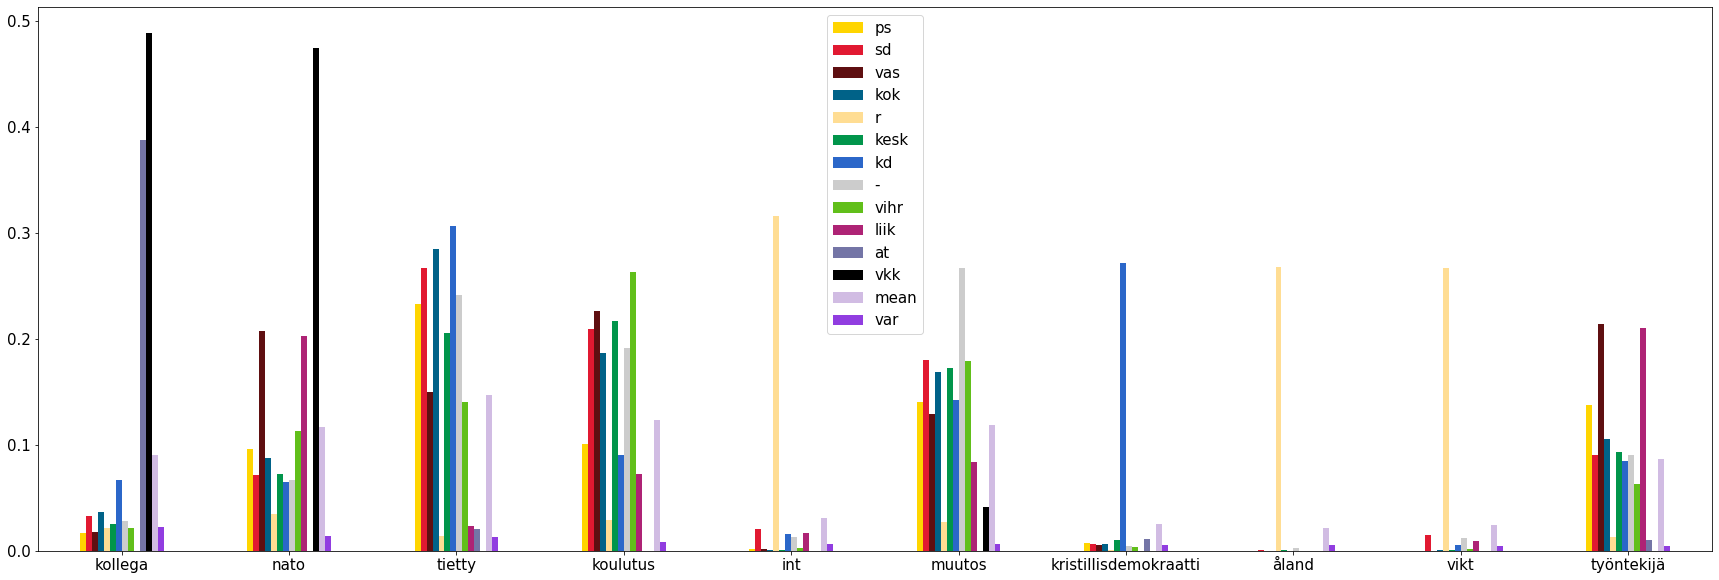

In [40]:
n=10
tfidf_092_025_top_n_var = tfidf_092_025.var().sort_values(ascending=False)[0:n]

tfidf_092_025[tfidf_092_025_top_n_var.index].T.plot.bar(rot=0, color=color_dict)

The chart above proves **specific mannerisms of one-person-groups (liik, at, vkk) are kind of biased when trying to compare the bigger groups**. While with this logic, KD is also more biased.

Let's get rid of the one-person groups for now.

We had words like "åland" and "finland" here, still. Sorry RKP but this just isn't gonna work out. Not with mixing primarily Swedish and Finnish documents.

Variance doesn't have much purpose here, either, as it is considerably lower either way

In [18]:
tfidf_092_025_dropped = tfidf_092_025.drop(labels=["liik", "vkk", "at", "-", "r", "var"], axis="index")

Here I'll create a simple function to display k graphs with n groups of bars each. To display top k∙x phrases

In [19]:
def display_top_bars(tfidf_df:pd.DataFrame, var_or_mean:str, per_plot:int, plots:int, ylim:float=False, rotation:int=0):
    """
    var_or_mean:    string to indicate which is used to sort
    per_plot:       integer to display how many bars each plot has
    plots:          integer to display how many subsequent plots are plotted
    ylim:           the maximum y-value displayed in every plot. Can be used to set the same y-limit for each which will take differences between the plots into account
    rotation        rotation of labels in degrees. Useful to specify if multiple bars are plotted per plot to keep the labels readable
    """

    for i in range(plots):
        if var_or_mean == "mean":
            
            # note the slice at the end defines which are plotted
            # e.g. [i*per_plot]
            top_n = tfidf_df.mean().sort_values(ascending=False)[i*per_plot:(i+1)*per_plot]
            ax = tfidf_df[top_n.index].T.plot.bar(rot=rotation, color=color_dict)
            
            if ylim:
                ax.set_ylim(0,ylim)
            
        elif var_or_mean == "var":
            top_n = tfidf_df.var().sort_values(ascending=False)[i*per_plot:(i+1)*per_plot]
            ax = tfidf_df[top_n.index].T.plot.bar(rot=rotation, color=color_dict)
            
            if ylim:
                ax.set_ylim(0,ylim)
                
        else:
            print("var_or_mean should be either 'var' or 'mean'")
            return


#### TF-IDF max 11/12 & min 3/12

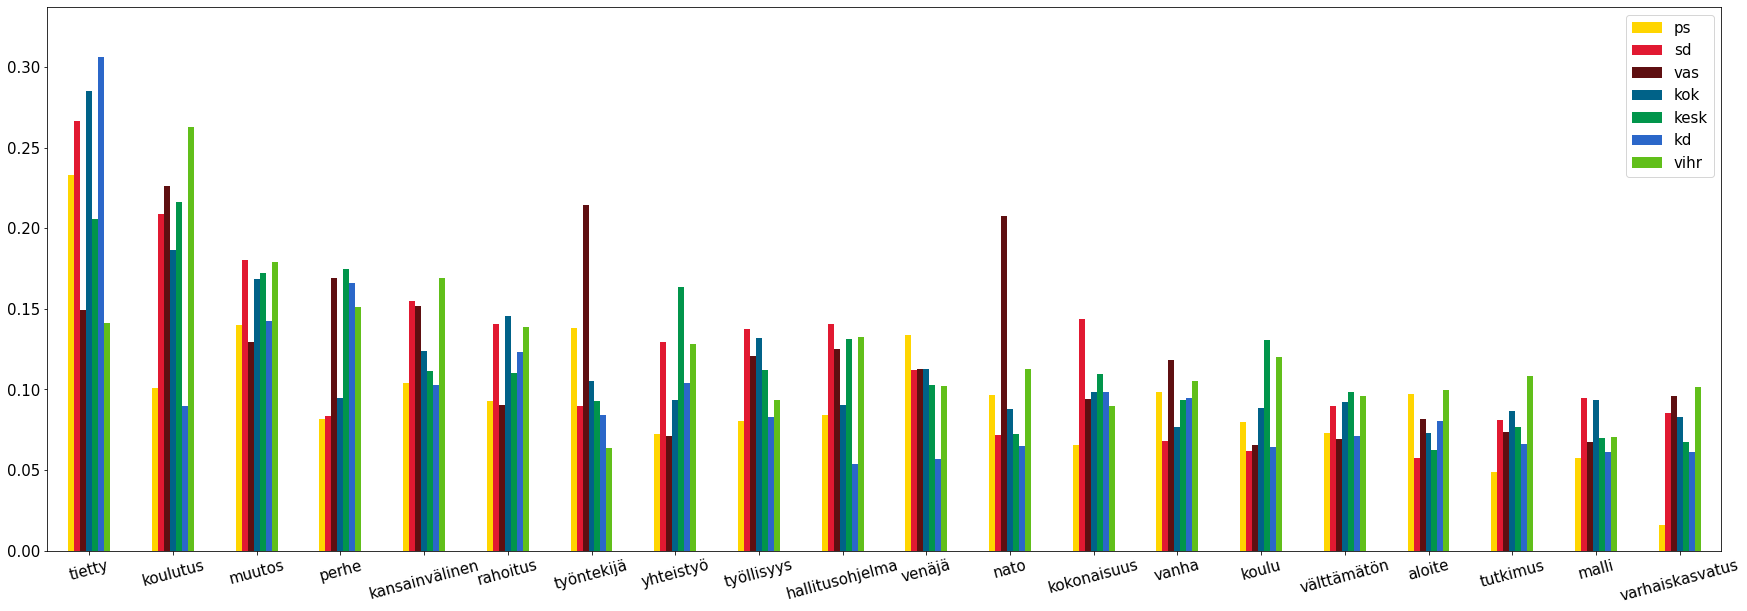

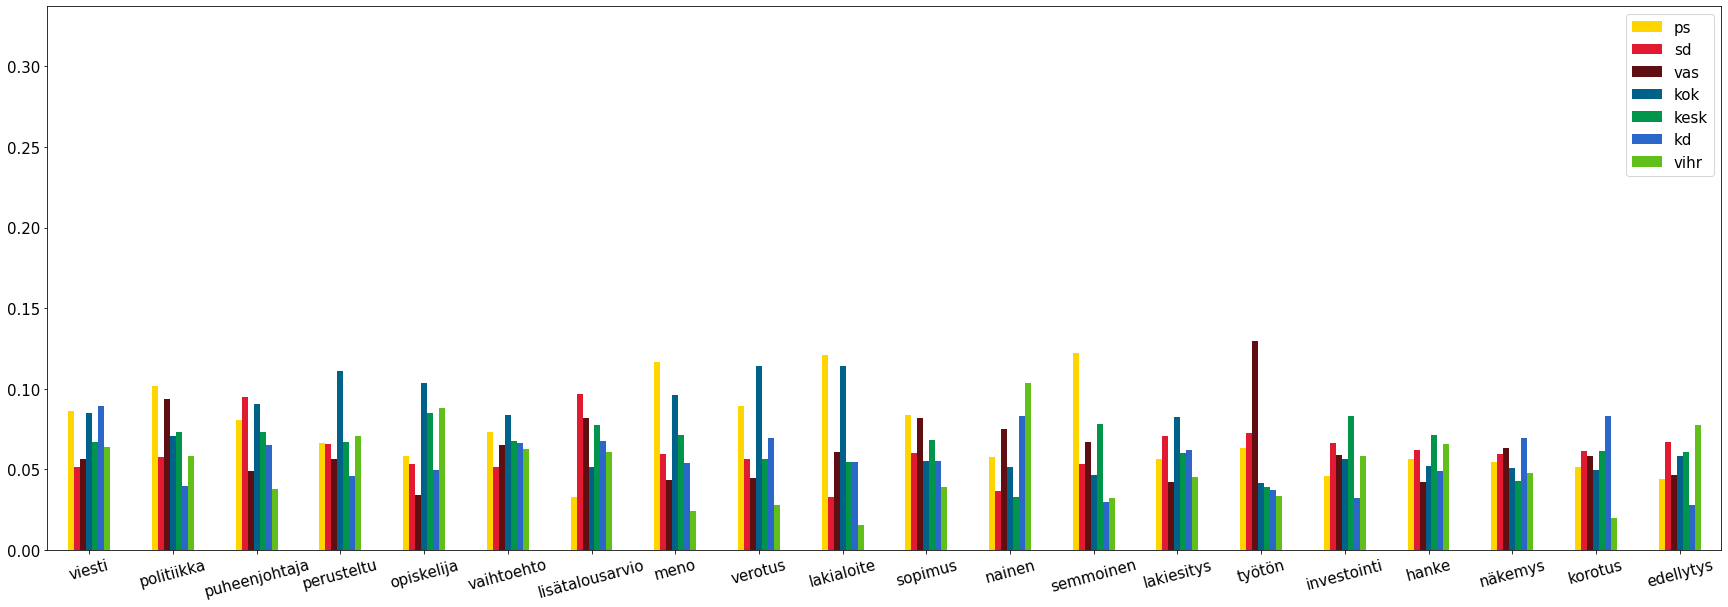

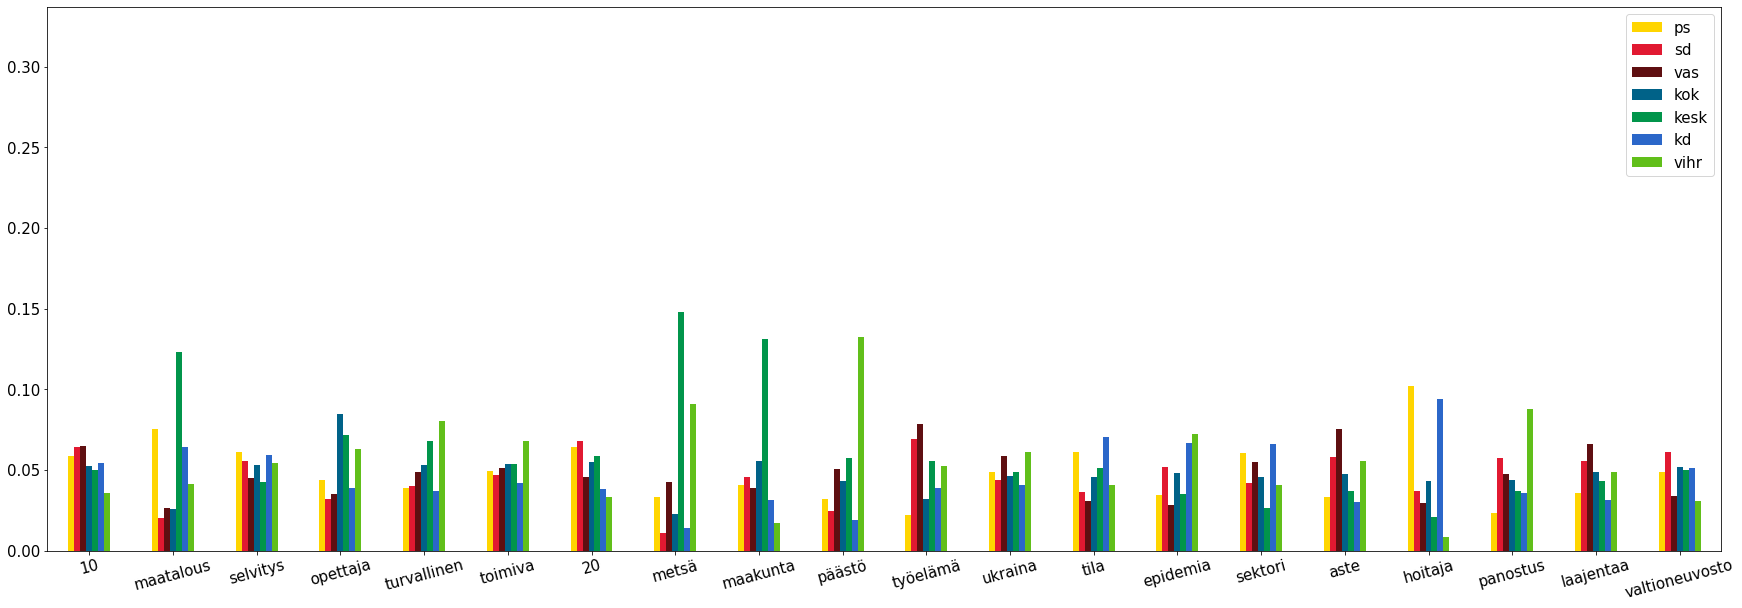

In [29]:
figsize(30,10)

# 110% of the maximum y-value; maximum column of maximums rows * 1.1
y_limit = tfidf_092_025_dropped.max().max()*1.1


display_top_bars(tfidf_092_025_dropped, "mean", per_plot=20, plots=3, ylim=y_limit, rotation=15)  # ylim of 0.35 happens to be slightly greater than the maximum TF-IDF value

#### TF-IDF max 12/12 & min 6/12

How about the popular words

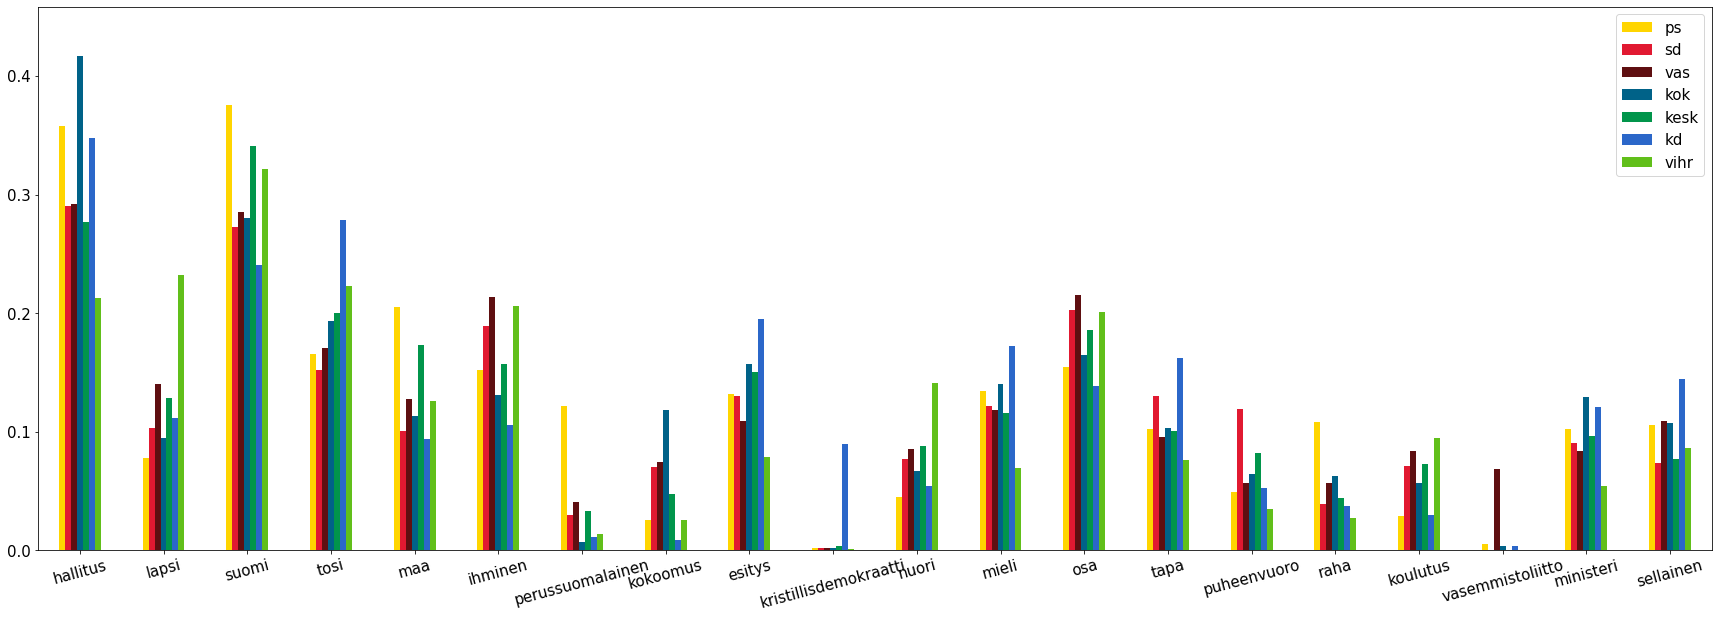

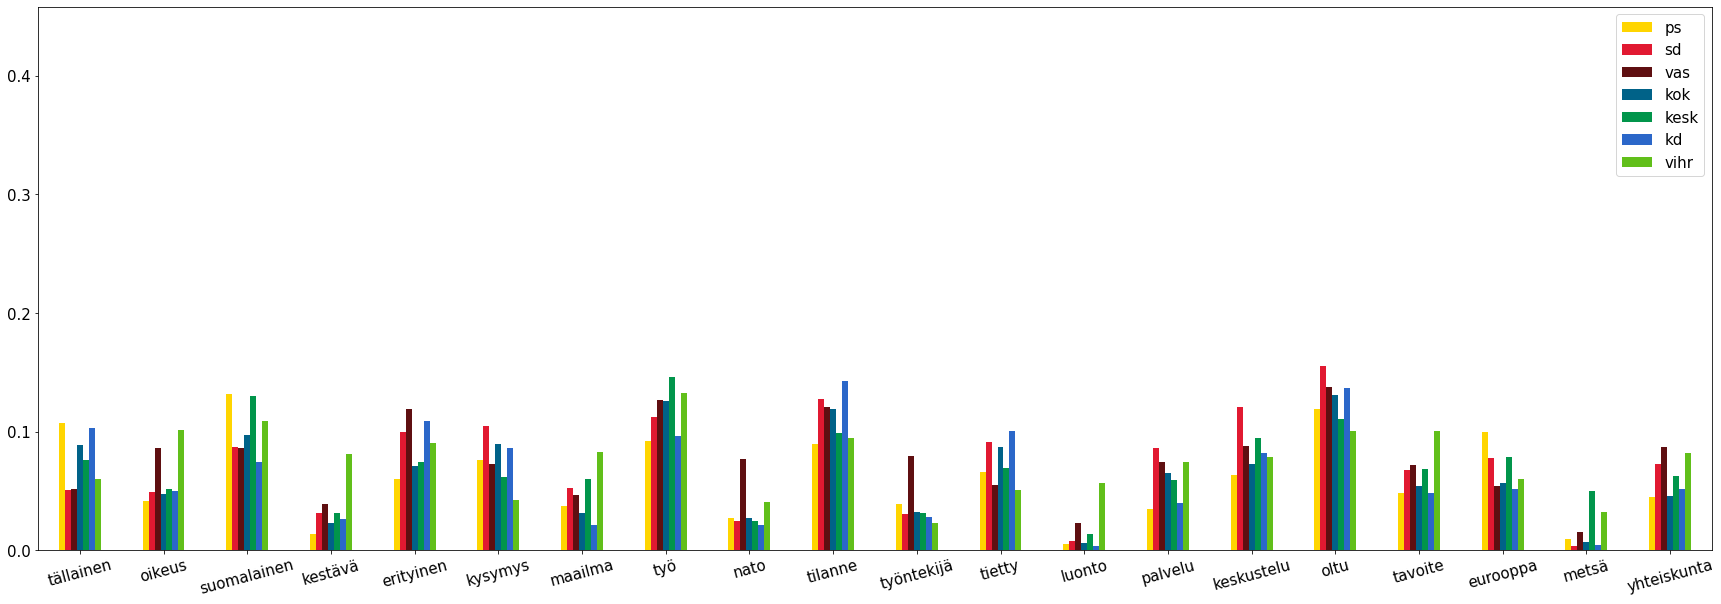

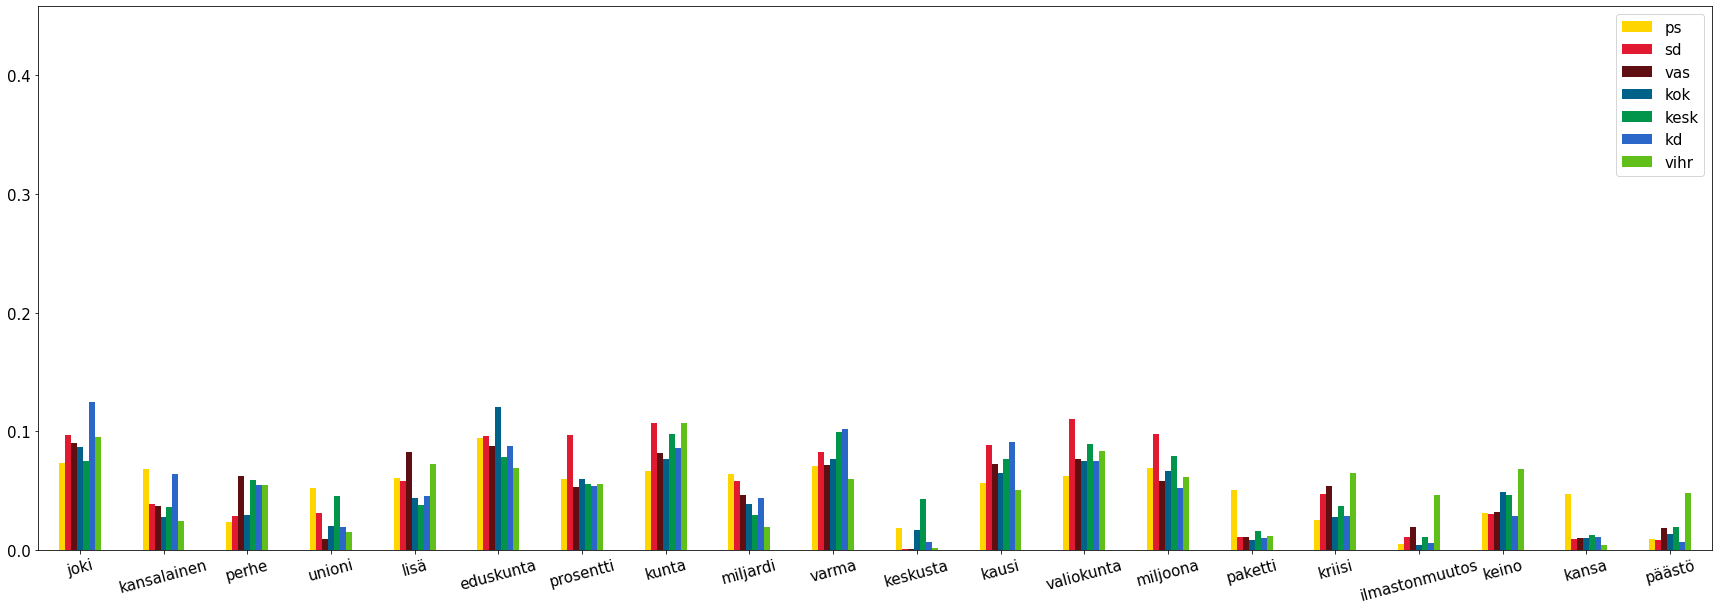

In [30]:
tfidf_100_050_dropped = tfidf_100_050.drop(labels=["liik", "vkk", "at", "-", "r", "var"], axis="index", errors="ignore")

# 110% of the maximum y-value; maximum column of maximums rows * 1.1
y_limit = tfidf_100_050_dropped.max().max()*1.1  

display_top_bars(tfidf_100_050_dropped, "var", per_plot=20, plots=3, ylim=y_limit, rotation=15)  # ylim of 0.35 happens to be slightly greater than the maximum TF-IDF value

#### TF-IDF max 6/12 & min 0/12

And the less popular words

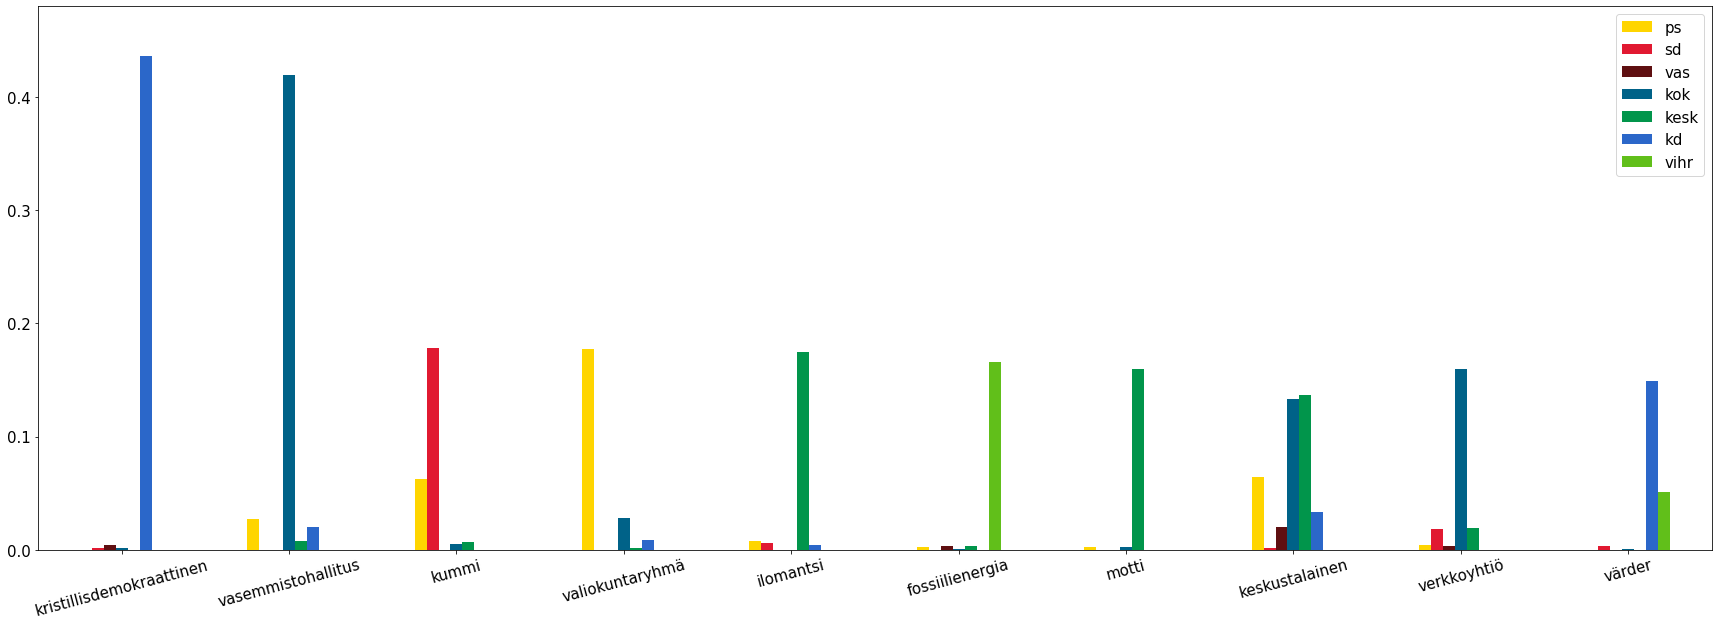

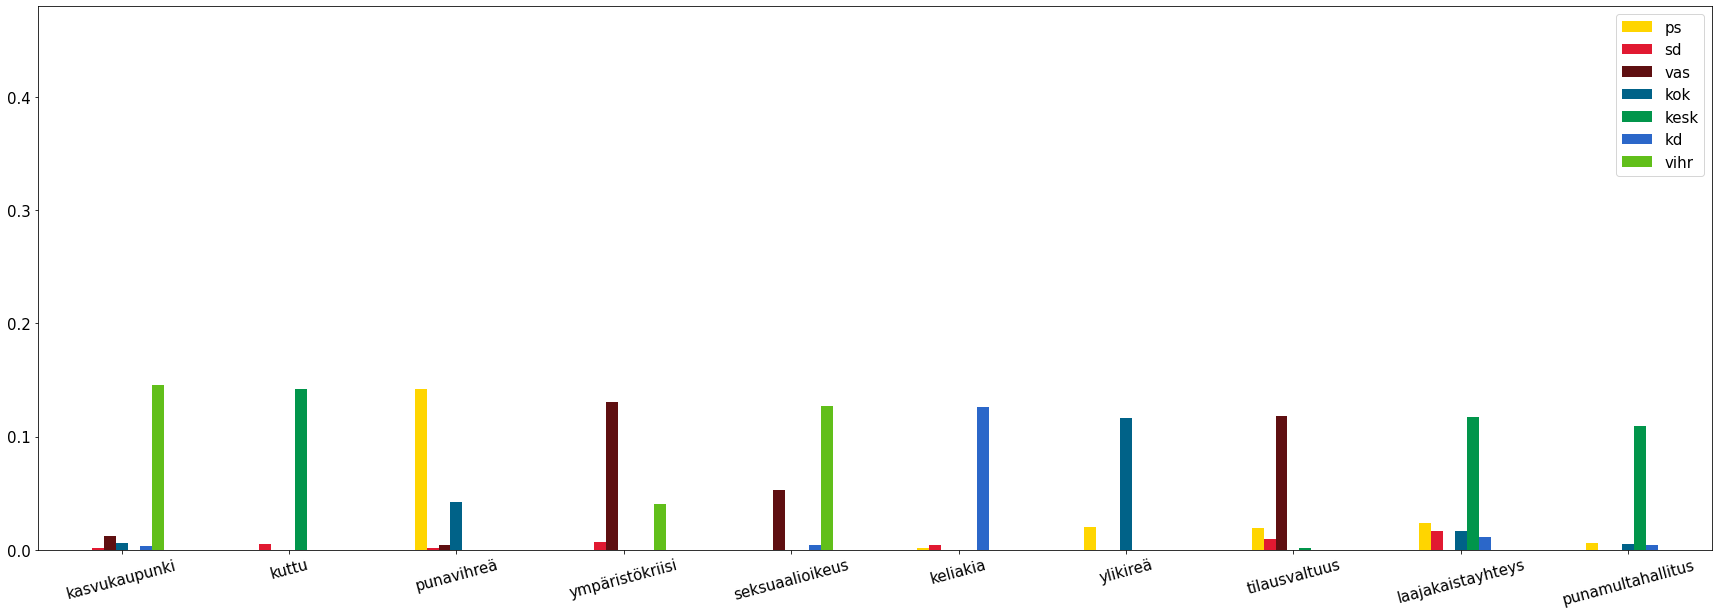

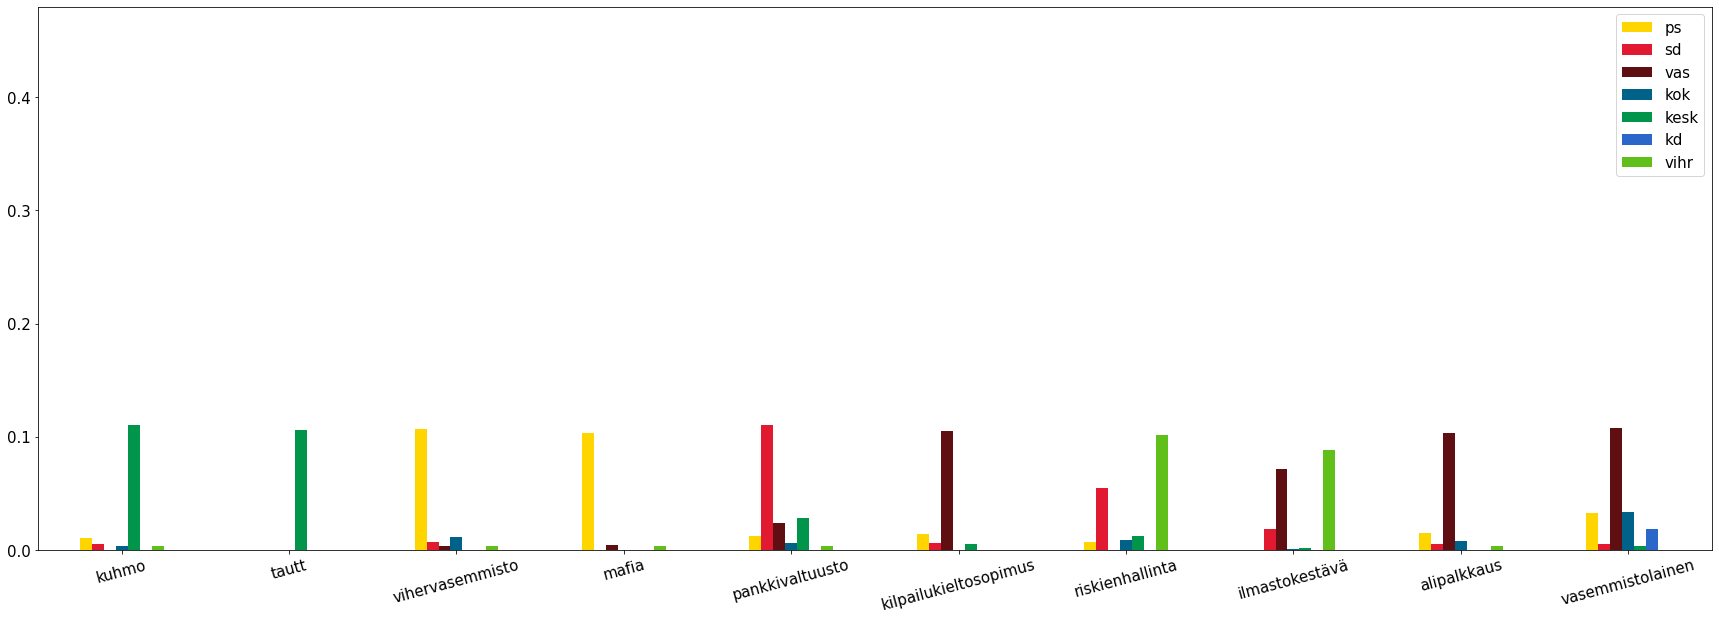

In [32]:
tfidf_050_000_dropped = tfidf_050_000.drop(labels=["liik", "vkk", "at", "-", "r", "var"], axis="index", errors="ignore")

# 110% of the maximum y-value; maximum column of maximums rows * 1.1
y_limit = tfidf_050_000_dropped.max().max()*1.1  

display_top_bars(tfidf_050_000_dropped, "var", per_plot=10, plots=3, ylim=y_limit, rotation=15)  # ylim of 0.35 happens to be slightly greater than the maximum TF-IDF value

#### TF-IDF max 10/12 & min 0/12

And for all words

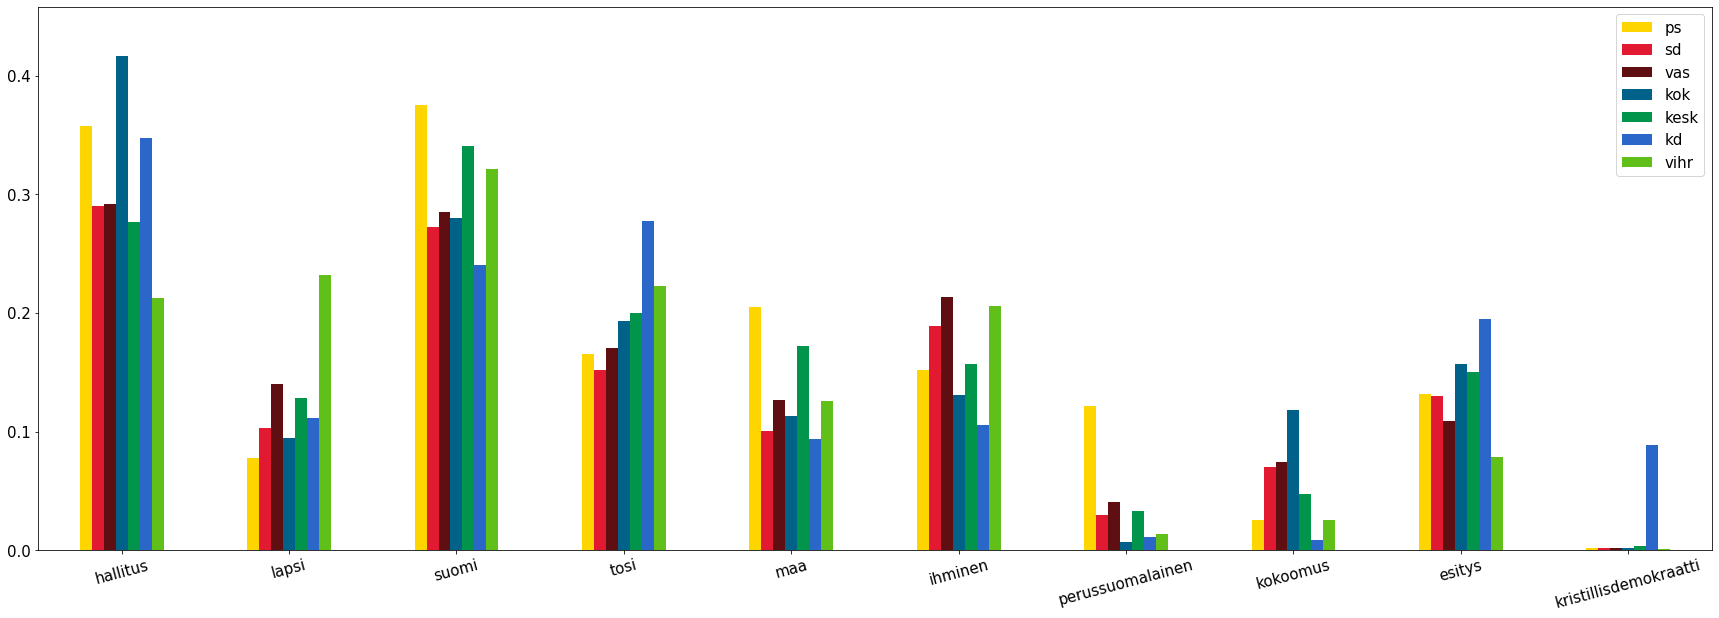

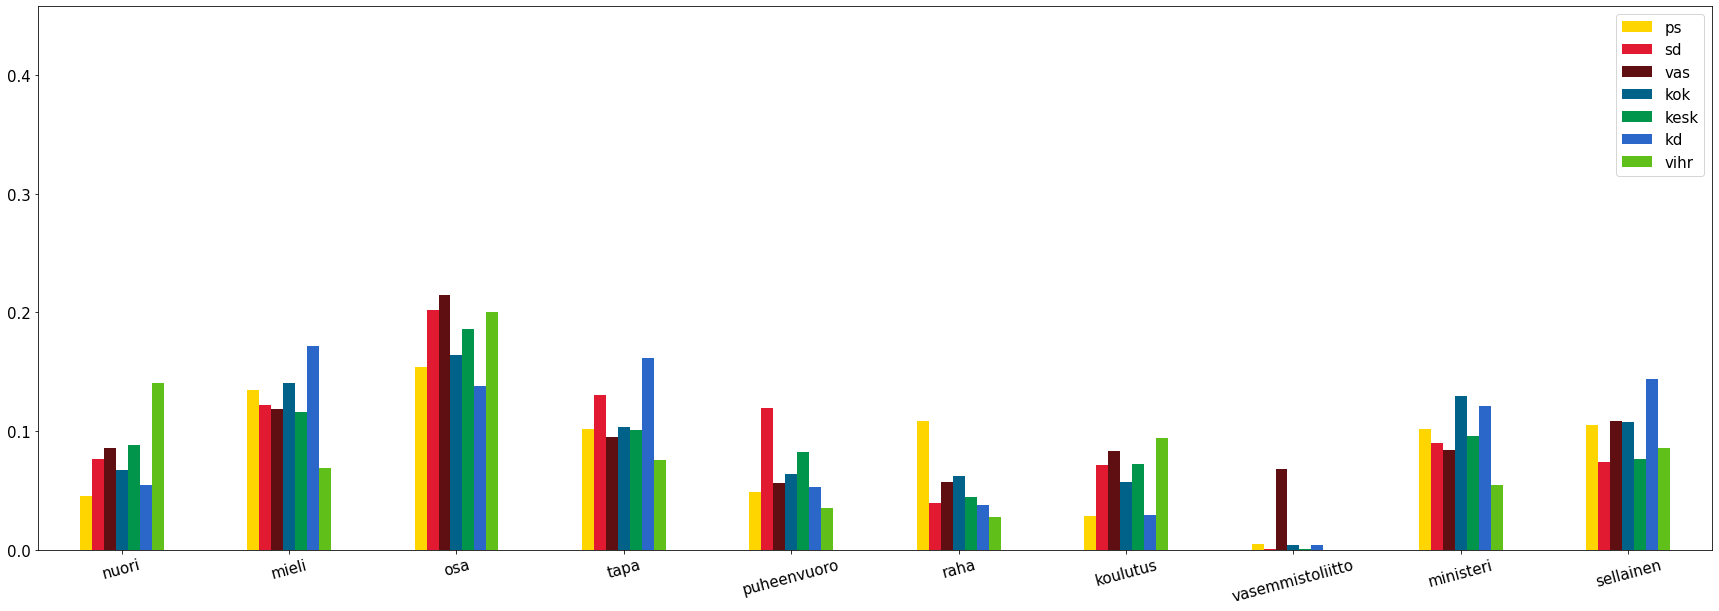

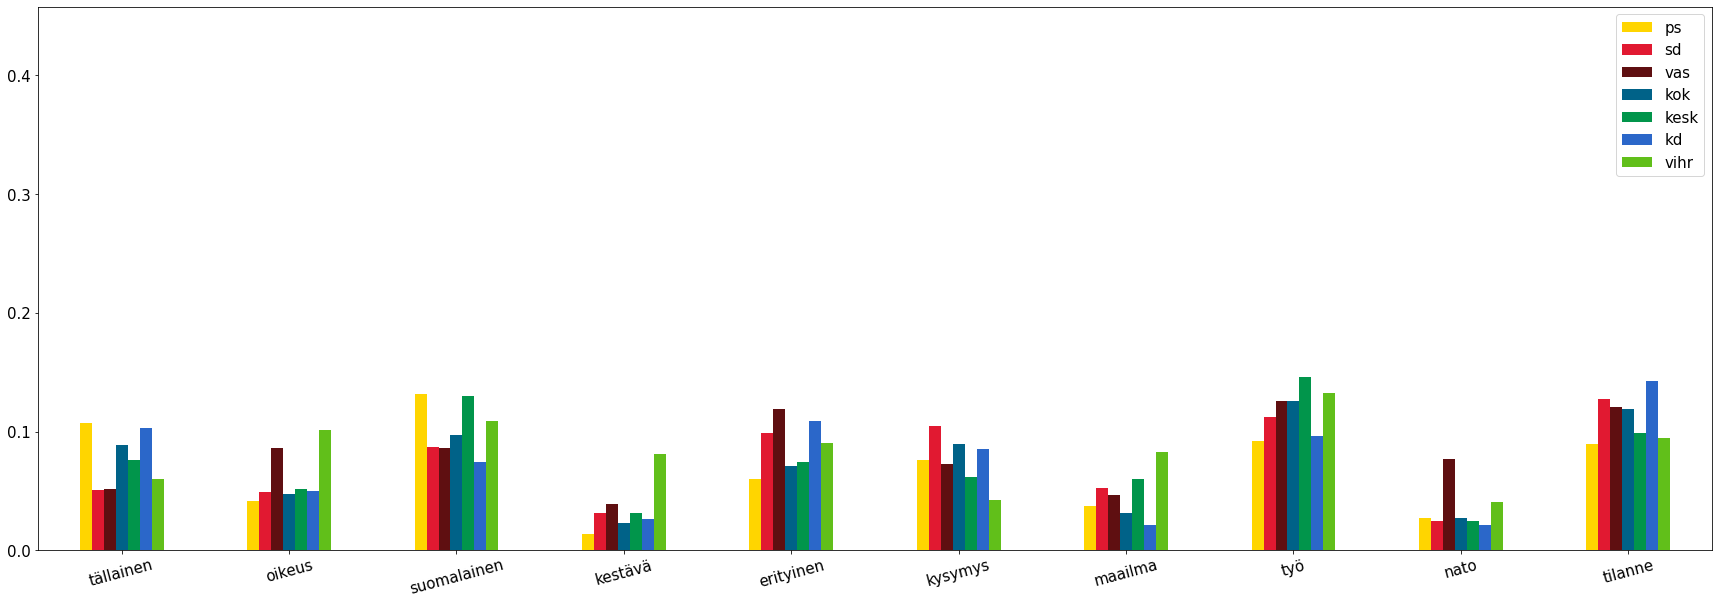

In [33]:
tfidf_100_000_dropped = tfidf_100_000.drop(labels=["liik", "vkk", "at", "-", "r", "var"], axis="index", errors="ignore")

# 110% of the maximum y-value; maximum column of maximums rows * 1.1
y_limit = tfidf_100_000_dropped.max().max()*1.1  

display_top_bars(tfidf_100_000_dropped, "var", per_plot=10, plots=3, ylim=y_limit, rotation=15)  # ylim of 0.35 happens to be slightly greater than the maximum TF-IDF value

### Correlation Matrix

* A correlation matrix is one way to measure the overall similarity of all the speeches (or documents of corpus)

<AxesSubplot:>

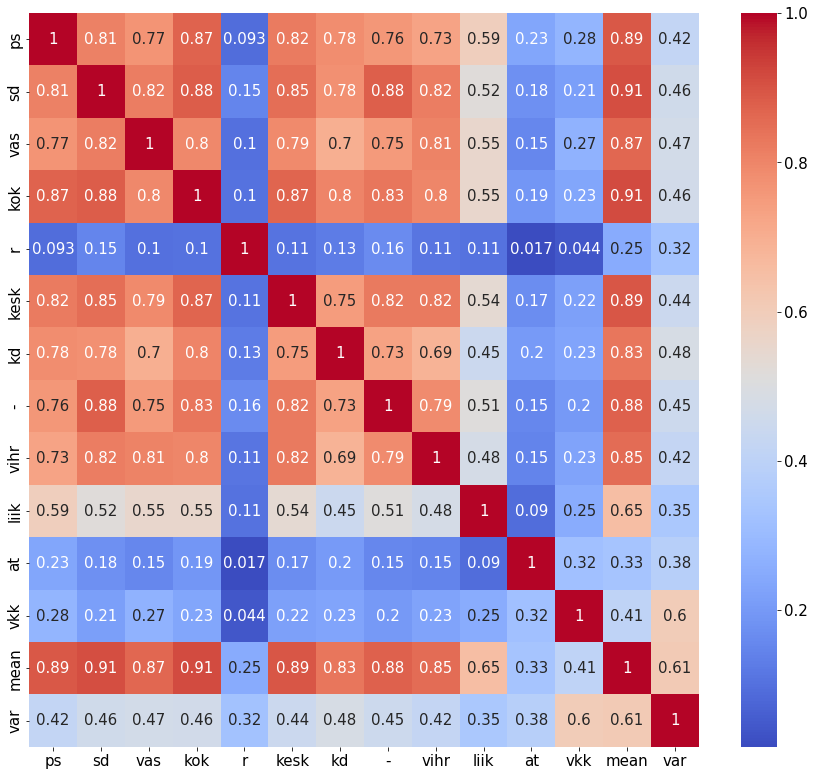

In [25]:
# tfidf_092_025.T.corr().style.background_gradient(cmap="coolwarm")
figsize(15,13.5)

sns.heatmap(tfidf_092_025.T.corr(), cmap="coolwarm", annot=True)

The plot above displays how r is supposedly very different given they speak Swedish. Hence, including them in the same analysis may not be a good idea

It is also shown how liik, and at & vkk differ greatly from the mean.

However, another interesting note is how at & vkk are also quite different from each other according to the correlation analysis, even though they're the same MP, though, from a slightly different time.

<AxesSubplot:>

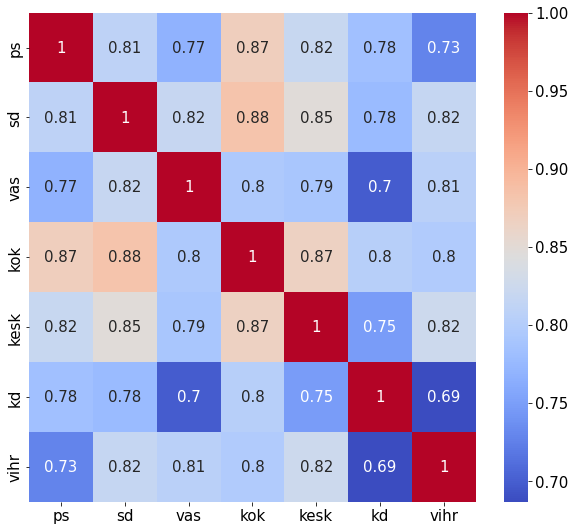

In [22]:
# tfidf_092_025_dropped.drop("mean").T.corr().style.background_gradient(cmap="coolwarm")
figsize(10,9)
sns.heatmap(tfidf_092_025_dropped.drop("mean").T.corr(), cmap="coolwarm", annot=True)

* It is vital to note ***depending on the selection of max_df nad min_df, some words are entirely excluded***

*If we now compare* the different correlation matrices for different parties, it becomes apparent that with a biased selection it is easy to have the data look very different

#1  First, view the correlation matrix which excludes words included in speeches of every party, max_df:0.92 and min_df:0.25
#2  Afterwards, display the same groups but only now include the most common words, too, but also exclude words which weren't mentioned by at least 50% of parties at least once
#3  How about for the least common words, which were mentioned by the half of groups at most. Note this still includes the one.person parties
#4  Lastly, include actually everything


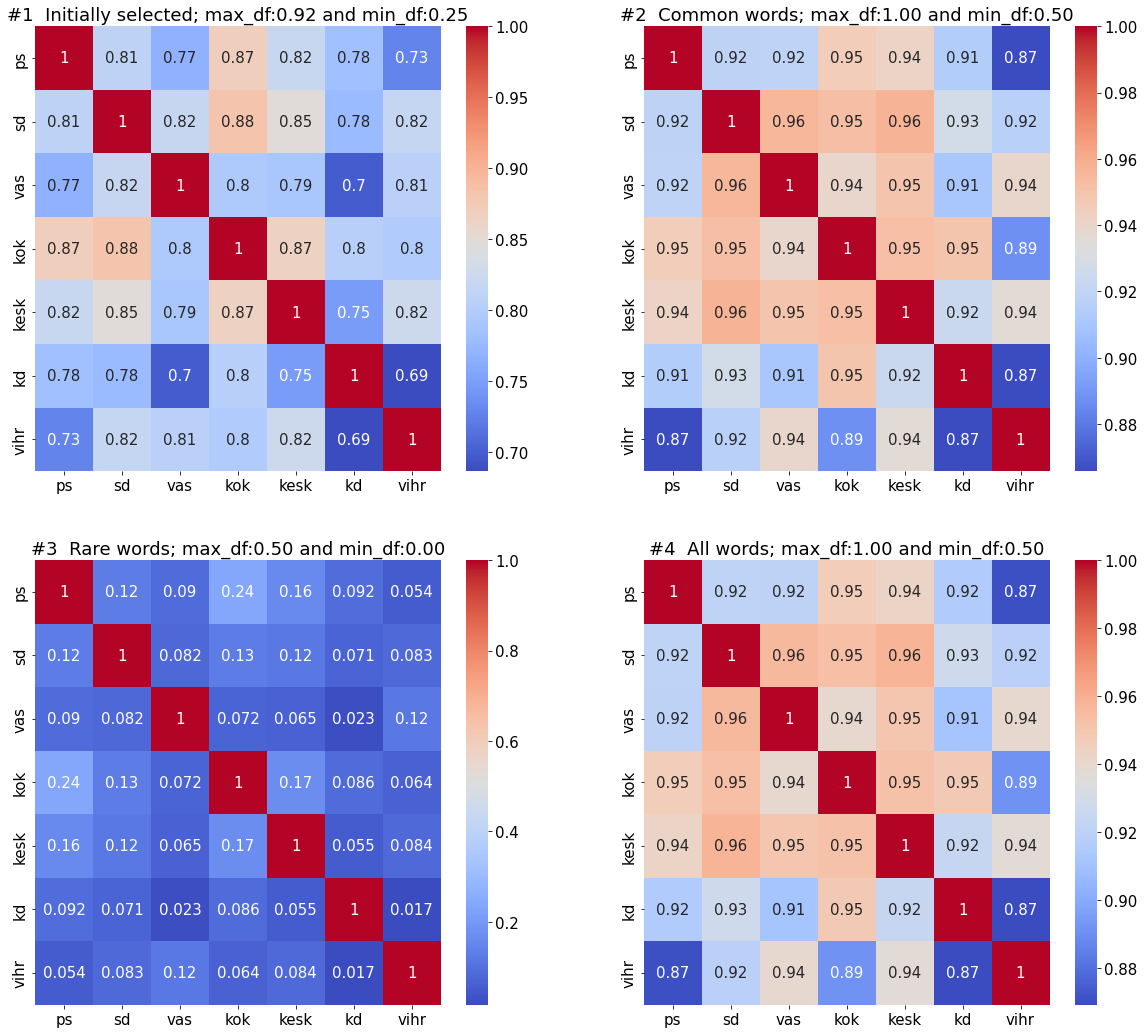

In [23]:
# https://stackoverflow.com/questions/23876588/matplotlib-colorbar-in-each-subplot
from mpl_toolkits.axes_grid1 import make_axes_locatable

figsize(20,18)

print(f"#1  First, view the correlation matrix which excludes words included in speeches of every party, max_df:{11/12:.2f} and min_df:{3/12:.2f}")
print(f"#2  Afterwards, display the same groups but only now include the most common words, too, but also exclude words which weren't mentioned by at least 50% of parties at least once")
print(f"#3  How about for the least common words, which were mentioned by the half of groups at most. Note this still includes the one.person parties")
print(f"#4  Lastly, include actually everything")

# The following logic will be used in the other displays, too.
# .T to get transpose which is required for teh correlation matrix
tfidf_092_025_dropped = tfidf_092_025_dropped.drop("mean", errors="ignore")
tfidf_092_025_dropped_correlation_matrix = tfidf_092_025_dropped.T.corr()
tfidf_092_025_dropped_correlation_matrix_styled = tfidf_092_025_dropped_correlation_matrix.style.background_gradient(cmap="coolwarm")

titles = [
    f"#1  Initially selected; max_df:{11/12:.2f} and min_df:{3/12:.2f}",
    f"#2  Common words; max_df:{1:.2f} and min_df:{0.5:.2f}",
    f"#3  Rare words; max_df:{0.5:.2f} and min_df:{0:.2f}",
    f"#4  All words; max_df:{1:.2f} and min_df:{0.5:.2f}"
]

tfidf_corr_matrices = [
    tfidf_092_025_dropped_correlation_matrix,
    tfidf_100_050.drop(labels=["liik", "vkk", "at", "-", "r"], axis="index").T.corr(),
    tfidf_050_000.drop(labels=["liik", "vkk", "at", "-", "r"], axis="index").T.corr(),
    tfidf_100_000.drop(labels=["liik", "vkk", "at", "-", "r"], axis="index").T.corr()
]

fig, axs = plt.subplots(nrows=2, ncols=2)
for i, current_tfidf_matrix in enumerate(tfidf_corr_matrices):
    current_ax = axs.flatten()[i]
    sns.heatmap(current_tfidf_matrix, ax=current_ax, cmap="coolwarm", annot=True)
    current_ax.set_title(titles[i])


In [26]:
# NOTE an additional way to display data:
# (pd.DataFrame.style color formatting doesn't seem to work e.g. on Github, though)
# for current_tfidf_matrix in tfidf_corr_matrices:
#     display(current_tfidf_matrix.style.background_gradient(cmap="coolwarm"))

Based on these correlation matrices, it can be stated to no surprise that the most common topics are talked about nearly everybody to a similar extent, and their TF-IDF-values are quite similar.

One thing **not** highlighted here is how large percentage words used in calculating each matrix constitute of. That is, whether the very popular words constitute of the majority or something different.